In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from bs4 import BeautifulSoup 
import requests
from datetime import datetime as dt
import plotly.subplots as sp
from pandas.tseries.offsets import MonthEnd

from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen

from RGGI_plant_analysis import RGGI_capacity

In [2]:
eia_html = requests.get('https://www.eia.gov/electricity/data/eia923/')
soup = BeautifulSoup(eia_html.content,'html.parser')
release_dates= soup.find_all('div',class_='release-dates')


In [3]:
next_update_time = release_dates[0].find_all('span',class_='date')[-1].text

In [4]:
monthly_report_links = {}

In [5]:
this_year =dt.today().year

In [6]:
dates_to_observe = range(this_year-5,this_year+1)

In [7]:
for x in soup.find_all('a', href=True):
    try:
        if int(x.attrs['title']) in dates_to_observe:
            monthly_report_links[x.attrs['title']] = x.attrs['href']
    except:
        pass

In [8]:
link_df = pd.DataFrame.from_dict(monthly_report_links,orient='index').sort_index()

In [10]:
mega_gen_fuel_df = pd.DataFrame()
for year in link_df.index:
    resp = urlopen('https://www.eia.gov/electricity/data/eia923/'+link_df.loc[year][0])
    myzip = ZipFile(BytesIO(resp.read()))
    for  x in myzip.filelist:
        if 'EIA923_Schedules_2_3_4_5_M' in x.filename:
            print(x.filename)
            gen_file = pd.ExcelFile(myzip.open(x))
            gen_fuel_df = pd.read_excel(gen_file,sheet_name='Page 1 Generation and Fuel Data',header=5)
            gen_fuel_df = gen_fuel_df.dropna(subset=['Plant Name'])

            mega_gen_fuel_df = pd.concat([mega_gen_fuel_df,gen_fuel_df],axis=0)

EIA923_Schedules_2_3_4_5_M_12_2019_Final_Revision.xlsx
Page 1 Energy Storage
Page 1 Generation and Fuel Data
Page 1 Puerto Rico
Page 2 Coal Stocks Data
Page 2 Oil Stocks Data
Page 2 Petcoke Stocks Data
Page 2 Stocks Data
Page 3 Boiler Fuel Data
Page 4 Generator Data
Page 5 Fuel Receipts and Costs
Page 6 Plant Frame
Page 6 Plant Frame Puerto Rico
EIA923_Schedules_2_3_4_5_M_12_2020_Final_Revision.xlsx
Page 1 Generation and Fuel Data
Page 1 Energy Storage
Page 1 Puerto Rico
Page 2 Coal Stocks Data
Page 2 Oil Stocks Data
Page 2 Petcoke Stocks Data
Page 2 Stocks Data
Page 3 Boiler Fuel Data
Page 4 Generator Data
Page 5 Fuel Receipts and Costs
Page 6 Plant Frame
Page 6 Plant Frame Puerto Rico
EIA923_Schedules_2_3_4_5_M_12_2021_Final_Revision.xlsx
Page 1 Energy Storage
Page 1 Generation and Fuel Data
Page 1 Puerto Rico
Page 2 Coal Stocks Data
Page 2 Oil Stocks Data
Page 2 Petcoke Stocks Data
Page 2 Stocks Data
Page 3 Boiler Fuel Data
Page 4 Generator Data
Page 5 Fuel Receipts and Costs
Page 6

In [11]:
### Capacity
def save_historical_capacity_per_plant():
    time_series_historical_capacity = pd.DataFrame()
    for x in range(1,12*6):
        next_update_time,recent_report,report_month,report_year  =RGGI_capacity().scrape_recent_EIA_860m(lagged_report=x)
        capacity = RGGI_capacity().analyse_all_capacity(recent_report,report_month,report_year)
        time_series_historical_capacity = pd.concat([time_series_historical_capacity,capacity],axis=0)

    time_series_historical_capacity.to_pickle('full_capacity_series.pkl')

    return time_series_historical_capacity

In [12]:
#time_series_historical_capacity = save_historical_capacity_per_plant()

In [13]:
time_series_historical_capacity = pd.read_pickle('full_capacity_series.pkl')

In [14]:
time_series_historical_capacity

Nameplate Capacity (MW)
Plant ID Energy Source Code Prime Mover Code Plant State report_month report_year                         
1.0      DFO                IC               AK          9            2024                             2.7
         WND                WT               AK          9            2024                             1.0
2.0      WAT                HY               AL          9            2024                            53.9
3.0      BIT                ST               AL          9            2024                          1192.5
         NG                 CA               AL          9            2024                           700.4
...                                                                                                    ...
62264.0  SUN                PV               MA          11           2018                             1.2
62265.0  SUN                PV               MA          11           2018                             1.9
62266.0  SUN                PV               MA          11           2018                             1.1
62270.0  DFO                IC               NY          11           2018                             8.0
62271.0  DFO                IC               NY          11           2018                             4.5

[879099 rows x 1 columns]

In [15]:
gen_cols = list(mega_gen_fuel_df.columns[['Netgen' in x for x in mega_gen_fuel_df.columns]])

In [17]:
#gen_cols.append('YEAR')

In [18]:
gen_cols

['Netgen\nJanuary',
 'Netgen\nFebruary',
 'Netgen\nMarch',
 'Netgen\nApril',
 'Netgen\nMay',
 'Netgen\nJune',
 'Netgen\nJuly',
 'Netgen\nAugust',
 'Netgen\nSeptember',
 'Netgen\nOctober',
 'Netgen\nNovember',
 'Netgen\nDecember']

In [19]:
RGGI_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT'] 

In [20]:
mega_gen_fuel_df['RGGI_state'] = np.where(mega_gen_fuel_df['Plant State'].isin(RGGI_states),1,0)

In [21]:
mega_gen_fuel_df['Reported\nPrime Mover'].unique()

array(['IC', 'WT', 'HY', 'CA', 'CT', 'ST', 'GT', 'PS', 'CS', 'PV', 'BA',
       'CE', 'BT', 'OT', 'FC', 'CP', 'FW', 'WS', 'WY'], dtype=object)

In [22]:
mega_gen_fuel_df['Reported\nFuel Type Code'].unique()

array(['DFO', 'WND', 'WAT', 'NG', 'BIT', 'SUB', 'NUC', 'LIG', 'PG', 'RC',
       'AB', 'WDS', 'RFO', 'LFG', 'PC', 'SUN', 'OBG', 'GEO', 'MWH', 'OG',
       'WO', 'JF', 'KER', 'OTH', 'WC', 'SGC', 'OBS', 'TDF', 'BFG', 'MSB',
       'MSN', 'SC', 'BLQ', 'WH', 'OBL', 'SLW', 'PUR', 'WDL', 'SGP', 'ANT',
       'H2'], dtype=object)

In [23]:
PJM_tech_dict = {'DFO':'Oil', 
                 'RFO':'Oil',
                 'WND':'Wind', 
                 'LFG':'Other Renewables', 
                 'PC':'Coal', 
                 'SUN':'Solar', 
                 'OBG':'Other Renewables', 
                 'GEO':'Other Renewables', 
                 'MWH':'Other', 
                 'OG':'Gas',
                'WO':'Oil', 
       'JF':'Oil', 
       'KER':'Oil', 
       'OTH':'Other', 
       'WC':'Coal', 
       'SGC':'Gas', 
       'OBS':'Other Renewables',
        'AB':'Other Renewables', 
        'TDF':'Other', 
        'BFG':'Gas',
        'MSB':'Other',
       'MSN':'Other Renewables', 
       'SC':'Coal',
       'SUB':'Coal',
       'LIG':'Coal',
       'BIT':'Coal','RC':'Coal','ANT':'Coal','NG':'Gas','PG':'Gas',
       'BLQ':'Other Renewables',
       'WH':'Other', 'WDS':'Other Renewables',
       'OBL':'Other Renewables', 'SLW':'Other Renewables', 
       'PUR':'Other', 'WDL':'Other Renewables', 'SGP':'Gas',
       'H2':'Hydro','WAT':'Hydro','BAT':'Storage','PS':'Storage','NUC':'Nuclear'}

Fossil_tech = ['Coal','Gas','Oil']

In [24]:
time_series_historical_capacity.index.get_level_values(1).unique()

Index(['DFO', 'WND', 'WAT', 'BIT', 'NG', 'NUC', 'SUB', 'MWH', 'SUN', 'GEO',
       'KER', 'RFO', 'WDS', 'JF', 'SGC', 'OG', 'PC', 'MSW', 'LFG', 'RC', 'LIG',
       'WC', 'WO', 'PG', 'OTH', 'WH', 'BLQ', 'OBG', 'BFG', 'WDL', 'AB', 'PUR',
       'OBL', 'OBS', 'SGP', 'TDF'],
      dtype='object', name='Energy Source Code')

In [25]:
rggi_or_pjm = mega_gen_fuel_df[(mega_gen_fuel_df['RGGI_state']==1)| (mega_gen_fuel_df['Balancing\nAuthority Code']=='PJM')]

In [26]:
rggi_or_pjm['Plant State'].unique()

array(['KY', 'NY', 'IL', 'CT', 'MA', 'VT', 'DE', 'MD', 'ME', 'IN', 'MI',
       'NH', 'NJ', 'NC', 'OH', 'PA', 'RI', 'VA', 'WV', 'TN', 'DC', 'MN'],
      dtype=object)

In [27]:
gen_cols

['Netgen\nJanuary',
 'Netgen\nFebruary',
 'Netgen\nMarch',
 'Netgen\nApril',
 'Netgen\nMay',
 'Netgen\nJune',
 'Netgen\nJuly',
 'Netgen\nAugust',
 'Netgen\nSeptember',
 'Netgen\nOctober',
 'Netgen\nNovember',
 'Netgen\nDecember']

In [28]:
rggi_or_pjm.columns

Index(['Plant Id', 'Combined Heat And\nPower Plant', 'Nuclear Unit Id',
       'Plant Name', 'Operator Name', 'Operator Id', 'Plant State',
       'Census Region', 'NERC Region', 'Reserved', 'NAICS Code',
       'EIA Sector Number', 'Sector Name', 'Reported\nPrime Mover',
       'Reported\nFuel Type Code', 'AER\nFuel Type Code',
       'Balancing\nAuthority Code', 'Respondent\nFrequency',
       'Physical\nUnit Label', 'Quantity\nJanuary', 'Quantity\nFebruary',
       'Quantity\nMarch', 'Quantity\nApril', 'Quantity\nMay', 'Quantity\nJune',
       'Quantity\nJuly', 'Quantity\nAugust', 'Quantity\nSeptember',
       'Quantity\nOctober', 'Quantity\nNovember', 'Quantity\nDecember',
       'Elec_Quantity\nJanuary', 'Elec_Quantity\nFebruary',
       'Elec_Quantity\nMarch', 'Elec_Quantity\nApril', 'Elec_Quantity\nMay',
       'Elec_Quantity\nJune', 'Elec_Quantity\nJuly', 'Elec_Quantity\nAugust',
       'Elec_Quantity\nSeptember', 'Elec_Quantity\nOctober',
       'Elec_Quantity\nNovember', 'Ele

In [29]:
fuel_cons_columns = ['Quantity\nJanuary', 'Quantity\nFebruary',
       'Quantity\nMarch', 'Quantity\nApril', 'Quantity\nMay', 'Quantity\nJune',
       'Quantity\nJuly', 'Quantity\nAugust', 'Quantity\nSeptember',
       'Quantity\nOctober', 'Quantity\nNovember', 'Quantity\nDecember']

mmbtu_cols = ['Tot_MMBtu\nJanuary', 'Tot_MMBtu\nFebruary', 'Tot_MMBtu\nMarch',
       'Tot_MMBtu\nApril', 'Tot_MMBtu\nMay', 'Tot_MMBtu\nJune',
       'Tot_MMBtu\nJuly', 'Tot_MMBtu\nAugust', 'Tot_MMBtu\nSeptember',
       'Tot_MMBtu\nOctober', 'Tot_MMBtu\nNovember', 'Tot_MMBtu\nDecember']

In [30]:
rggi_or_pjm[gen_cols] = rggi_or_pjm[gen_cols].replace('.',0)
rggi_or_pjm[fuel_cons_columns] = rggi_or_pjm[fuel_cons_columns].replace('.',0)
rggi_or_pjm[mmbtu_cols] = rggi_or_pjm[mmbtu_cols].replace('.',0)

C:\Users\Alex Child\AppData\Local\Temp\ipykernel_39220\3169541333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rggi_or_pjm[gen_cols] = rggi_or_pjm[gen_cols].replace('.',0)
C:\Users\Alex Child\AppData\Local\Temp\ipykernel_39220\3169541333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rggi_or_pjm[fuel_cons_columns] = rggi_or_pjm[fuel_cons_columns].replace('.',0)
C:\Users\Alex Child\AppData\Local\Temp\ipykernel_39220\3169541333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [31]:
mmbtu_df = rggi_or_pjm.groupby(['Plant Id','Plant State','Reported\nFuel Type Code','YEAR'])[mmbtu_cols].sum().stack().to_frame('Fuel_consumed_Mmbtu')
mmbtu_df['month'] = [x[-1] for x in mmbtu_df.reset_index()['level_4'].str.split('\n')]
mmbtu_df=mmbtu_df.reset_index()
mmbtu_df['Date'] = pd.to_datetime('01/'+mmbtu_df['month']+'/'+mmbtu_df['YEAR'].astype(str))+MonthEnd(0)
mmbtu_df['month'] = mmbtu_df['Date'].dt.month

In [32]:
"""
fuel_cons_df = rggi_or_pjm.groupby(['Plant Id','Plant State','Reported\nPrime Mover','Reported\nFuel Type Code','Physical\nUnit Label','YEAR'])[fuel_cons_columns].sum().stack().to_frame('Fuel_consumed_q')
fuel_cons_df['month'] = [x[-1] for x in fuel_cons_df.reset_index()['level_6'].str.split('\n')]
fuel_cons_df=fuel_cons_df.reset_index()
fuel_cons_df['Date'] = pd.to_datetime('01/'+fuel_cons_df['month']+'/'+fuel_cons_df['YEAR'].astype(str))+MonthEnd(0)
fuel_cons_df['month'] = fuel_cons_df['Date'].dt.month"""

"\nfuel_cons_df = rggi_or_pjm.groupby(['Plant Id','Plant State','Reported\nPrime Mover','Reported\nFuel Type Code','Physical\nUnit Label','YEAR'])[fuel_cons_columns].sum().stack().to_frame('Fuel_consumed_q')\nfuel_cons_df['month'] = [x[-1] for x in fuel_cons_df.reset_index()['level_6'].str.split('\n')]\nfuel_cons_df=fuel_cons_df.reset_index()\nfuel_cons_df['Date'] = pd.to_datetime('01/'+fuel_cons_df['month']+'/'+fuel_cons_df['YEAR'].astype(str))+MonthEnd(0)\nfuel_cons_df['month'] = fuel_cons_df['Date'].dt.month"

In [33]:
mmbtu_df = mmbtu_df.groupby(['Plant Id','Plant State','Date','Reported\nFuel Type Code'])['Fuel_consumed_Mmbtu'].sum().unstack('Reported\nFuel Type Code').fillna(0)#.add_suffix('_mmbtu')

In [36]:
from EIA_emissions_factors import download_EF_from_EIA

In [37]:
EF_df = download_EF_from_EIA(fuels_list=mmbtu_df.columns)

In [38]:
EF_df

,KgCO2_perMmbtu
Reported Fuel Type Code,
AB,0
ANT,103.69
BFG,52.91
BIT,93.24
BLQ,0
DFO,74.14
JF,72.23
KER,73.19
LFG,0


In [39]:
plant_emissions = mmbtu_df.copy()

for x in mmbtu_df.columns:
    plant_emissions[x] = mmbtu_df[x]*float(EF_df.loc[x].values[0])

In [40]:
plant_emissions = (plant_emissions/1000)* 0.9071847

In [41]:
plant_emissions = plant_emissions.stack().to_frame('Emissions_stCO2')

In [42]:
rggi_or_pjm = rggi_or_pjm.groupby(['Plant Id','Plant Name','Reported\nFuel Type Code','Plant State', 'Balancing\nAuthority Code','RGGI_state','YEAR'])[gen_cols].sum().stack().to_frame('Generation MWh')

In [44]:
rggi_or_pjm['month'] = [x[-1] for x in rggi_or_pjm.reset_index()['level_7'].str.split('\n')]

In [45]:
rggi_or_pjm = rggi_or_pjm.reset_index()

In [46]:
rggi_or_pjm['Date'] = pd.to_datetime('01/'+rggi_or_pjm['month']+'/'+rggi_or_pjm['YEAR'].astype(str),format='%d/%B/%Y')+MonthEnd(0)

In [49]:
rggi_or_pjm['month'] = rggi_or_pjm['Date'].dt.month

In [50]:
time_series_historical_capacity_byprime_mover = time_series_historical_capacity.reset_index().groupby(['Plant ID', 'Energy Source Code','Plant State','report_month','report_year']).sum()

C:\Users\Alex Child\AppData\Local\Temp\ipykernel_39220\1925802119.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_series_historical_capacity_byprime_mover = time_series_historical_capacity.reset_index().groupby(['Plant ID', 'Energy Source Code','Plant State','report_month','report_year']).sum()


In [51]:
rggi_or_pjm_capacity = rggi_or_pjm.merge(time_series_historical_capacity_byprime_mover,left_on=['Plant Id','Reported\nFuel Type Code','Plant State','month','YEAR'],right_index=True,how='left')

In [52]:
gap_fill = rggi_or_pjm_capacity.groupby(['Plant Id','Reported\nFuel Type Code','YEAR'])['Nameplate Capacity (MW)'].mean().to_frame('Gap_fill_capacity_year')

In [53]:
rggi_or_pjm_capacity = rggi_or_pjm_capacity.merge(gap_fill,left_on=['Plant Id','Reported\nFuel Type Code','YEAR'],right_index=True,how='left')

In [54]:
rggi_or_pjm_capacity['Nameplate Capacity (MW)'] = np.where((rggi_or_pjm_capacity['Generation MWh']>0) & (pd.isna(rggi_or_pjm_capacity['Nameplate Capacity (MW)'])),
                                                           rggi_or_pjm_capacity['Gap_fill_capacity_year'],rggi_or_pjm_capacity['Nameplate Capacity (MW)'])


In [55]:
gap_fill = rggi_or_pjm_capacity.groupby(['Plant Id','Reported\nFuel Type Code'])['Nameplate Capacity (MW)'].mean().to_frame('Gap_fill_capacity_overall')

In [56]:
rggi_or_pjm_capacity = rggi_or_pjm_capacity.merge(gap_fill,left_on=['Plant Id','Reported\nFuel Type Code'],right_index=True,how='left')

rggi_or_pjm_capacity['Nameplate Capacity (MW)'] = np.where((rggi_or_pjm_capacity['Generation MWh']>0) & (pd.isna(rggi_or_pjm_capacity['Nameplate Capacity (MW)'])),
                                                           rggi_or_pjm_capacity['Gap_fill_capacity_overall'],rggi_or_pjm_capacity['Nameplate Capacity (MW)'])


In [57]:
rggi_or_pjm_capacity = rggi_or_pjm_capacity.join(plant_emissions,on=['Plant Id','Plant State','Date','Reported\nFuel Type Code'])

In [58]:
rggi_or_pjm_capacity['PJM_tech'] = rggi_or_pjm_capacity['Reported\nFuel Type Code'].map(PJM_tech_dict)

In [59]:
rggi_or_pjm_capacity['Generation MWh_clipped'] = rggi_or_pjm_capacity['Generation MWh'].clip(0,9999999999999999999999999999999999)

In [93]:
coal_dual_fuel = ((rggi_or_pjm_capacity.groupby(['Plant Id','Date','PJM_tech'])['Generation MWh_clipped'].sum().unstack('PJM_tech')[Fossil_tech].divide(rggi_or_pjm_capacity.groupby(['Plant Id','Date','PJM_tech'])['Generation MWh_clipped'].sum().unstack('PJM_tech')[Fossil_tech].sum(axis=1),axis=0)<0.9) &
             (rggi_or_pjm_capacity.groupby(['Plant Id','Date','PJM_tech'])['Generation MWh_clipped'].sum().unstack('PJM_tech')[Fossil_tech].divide(rggi_or_pjm_capacity.groupby(['Plant Id','Date','PJM_tech'])['Generation MWh_clipped'].sum().unstack('PJM_tech')[Fossil_tech].sum(axis=1),axis=0)>0.1))['Coal']

gas_dual_fuel = ((rggi_or_pjm_capacity.groupby(['Plant Id','Date','PJM_tech'])['Generation MWh_clipped'].sum().unstack('PJM_tech')[Fossil_tech].divide(rggi_or_pjm_capacity.groupby(['Plant Id','Date','PJM_tech'])['Generation MWh_clipped'].sum().unstack('PJM_tech')[Fossil_tech].sum(axis=1),axis=0)<0.9) &
             (rggi_or_pjm_capacity.groupby(['Plant Id','Date','PJM_tech'])['Generation MWh_clipped'].sum().unstack('PJM_tech')[Fossil_tech].divide(rggi_or_pjm_capacity.groupby(['Plant Id','Date','PJM_tech'])['Generation MWh_clipped'].sum().unstack('PJM_tech')[Fossil_tech].sum(axis=1),axis=0)>0.1))['Gas']

In [113]:
dual_fuel_df = rggi_or_pjm_capacity.groupby(['Plant Id','Date','PJM_tech'])['Generation MWh'].sum().unstack('PJM_tech')[coal_dual_fuel | gas_dual_fuel]

In [114]:
dual_fuel_df['Dual_fuel']=1

In [117]:
rggi_or_pjm_capacity = rggi_or_pjm_capacity.join(dual_fuel_df['Dual_fuel'],on=['Plant Id','Date'])

In [119]:
rggi_or_pjm_capacity['PJM_tech'] = np.where(rggi_or_pjm_capacity['Dual_fuel']==1,'Multiple Fuels',rggi_or_pjm_capacity['PJM_tech'])

In [63]:
px.bar(rggi_or_pjm_capacity.query('`Nameplate Capacity (MW)`>25 ').groupby(['YEAR','RGGI_state'])['Emissions_stCO2'].sum().unstack('RGGI_state'),barmode='group')

In [64]:
(rggi_or_pjm_capacity.query('`Nameplate Capacity (MW)`>25 and RGGI_state==1').groupby(['Plant State','YEAR','RGGI_state'])['Emissions_stCO2'].sum().unstack('YEAR')/10**6).sort_values('RGGI_state').sum()

YEAR
2019    68.586072
2020    64.941582
2021    68.155617
2022    70.755734
2023    67.391281
2024    46.652007
dtype: float64

In [65]:
px.bar(rggi_or_pjm_capacity.query('`Plant Name`=="Brandon Shores"').pivot_table(index='YEAR',columns='month',values='Emissions_stCO2').sum(axis=1))

In [66]:
rggi_or_pjm_capacity

,Plant Id,Plant Name,Reported\nFuel Type Code,Plant State,Balancing\nAuthority Code,RGGI_state,YEAR,level_7,Generation MWh,month,Date,Nameplate Capacity (MW),Gap_fill_capacity_year,Gap_fill_capacity_overall,Emissions_stCO2,PJM_tech,Generation MWh_clipped
0,54,J K Smith,BIT,KY,PJM,0,2020,Netgen\nJanuary,0.000,1,2020-01-31,NaN,NaN,NaN,0.0,Coal,0.000
1,54,J K Smith,BIT,KY,PJM,0,2020,Netgen\nFebruary,0.000,2,2020-02-29,NaN,NaN,NaN,0.0,Coal,0.000
2,54,J K Smith,BIT,KY,PJM,0,2020,Netgen\nMarch,0.000,3,2020-03-31,NaN,NaN,NaN,0.0,Coal,0.000
3,54,J K Smith,BIT,KY,PJM,0,2020,Netgen\nApril,0.000,4,2020-04-30,NaN,NaN,NaN,0.0,Coal,0.000
4,54,J K Smith,BIT,KY,PJM,0,2020,Netgen\nMay,0.000,5,2020-05-31,NaN,NaN,NaN,0.0,Coal,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268903,99999,State-Fuel Level Increment,WND,RI,State-Fuel Level Increment,1,2024,Netgen\nAugust,2886.634,8,2024-08-31,NaN,NaN,NaN,0.0,Wind,2886.634
268904,99999,State-Fuel Level Increment,WND,RI,State-Fuel Level Increment,1,2024,Netgen\nSeptember,3108.214,9,2024-09-30,NaN,NaN,NaN,0.0,Wind,3108.214
268905,99999,State-Fuel Level Increment,WND,RI,State-Fuel Level Increment,1,2024,Netgen\nOctober,0.000,10,2024-10-31,NaN,NaN,NaN,0.0,Wind,0.000
268906,99999,State-Fuel Level Increment,WND,RI,State-Fuel Level Increment,1,2024,Netgen\nNovember,0.000,11,2024-11-30,NaN,NaN,NaN,0.0,Wind,0.000


In [67]:
rggi_or_pjm_capacity.reset_index().query('`Plant Id`==1556')

,index,Plant Id,Plant Name,Reported\nFuel Type Code,Plant State,Balancing\nAuthority Code,RGGI_state,YEAR,level_7,Generation MWh,month,Date,Nameplate Capacity (MW),Gap_fill_capacity_year,Gap_fill_capacity_overall,Emissions_stCO2,PJM_tech,Generation MWh_clipped
8748,8748,1556,Perryman,DFO,MD,PJM,1,2019,Netgen\nJanuary,2340.266,1,2019-01-31,159.3,159.3,159.3,1557.643623,Oil,2340.266
8749,8749,1556,Perryman,DFO,MD,PJM,1,2019,Netgen\nFebruary,5087.871,2,2019-02-28,159.3,159.3,159.3,3760.970514,Oil,5087.871
8750,8750,1556,Perryman,DFO,MD,PJM,1,2019,Netgen\nMarch,1729.526,3,2019-03-31,159.3,159.3,159.3,1623.557123,Oil,1729.526
8751,8751,1556,Perryman,DFO,MD,PJM,1,2019,Netgen\nApril,573.245,4,2019-04-30,159.3,159.3,159.3,426.352732,Oil,573.245
8752,8752,1556,Perryman,DFO,MD,PJM,1,2019,Netgen\nMay,0.000,5,2019-05-31,159.3,159.3,159.3,0.000000,Oil,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8887,8887,1556,Perryman,NG,MD,PJM,1,2024,Netgen\nAugust,21664.146,8,2024-08-31,333.0,333.0,333.0,13661.515932,Gas,21664.146
8888,8888,1556,Perryman,NG,MD,PJM,1,2024,Netgen\nSeptember,6998.742,9,2024-09-30,333.0,333.0,333.0,4002.072501,Gas,6998.742
8889,8889,1556,Perryman,NG,MD,PJM,1,2024,Netgen\nOctober,0.000,10,2024-10-31,NaN,333.0,333.0,0.000000,Gas,0.000
8890,8890,1556,Perryman,NG,MD,PJM,1,2024,Netgen\nNovember,0.000,11,2024-11-30,NaN,333.0,333.0,0.000000,Gas,0.000


In [68]:
px.line(rggi_or_pjm_capacity.reset_index().query('`Plant Id`==1556'),x='Date',y='Emissions_stCO2',color='Reported\nFuel Type Code')

### PJM proportions

In [267]:
pjm = rggi_or_pjm_capacity[rggi_or_pjm_capacity['Balancing\nAuthority Code']=="PJM"]

In [268]:
total_pjm_gen = pjm.groupby(['Date','PJM_tech'])['Generation MWh_clipped'].sum().to_frame('Total_PJM_generation')

In [269]:
pjm = pjm.join(total_pjm_gen,on=['Date','PJM_tech'])

In [270]:
pjm['Generation_share_PJM'] = pjm['Generation MWh_clipped']/pjm['Total_PJM_generation']

In [272]:
rggi_share = pjm.groupby(['YEAR','month','Date','PJM_tech','RGGI_state'])['Generation MWh_clipped'].sum().unstack('RGGI_state')

<AxesSubplot:xlabel='YEAR,month,Date'>

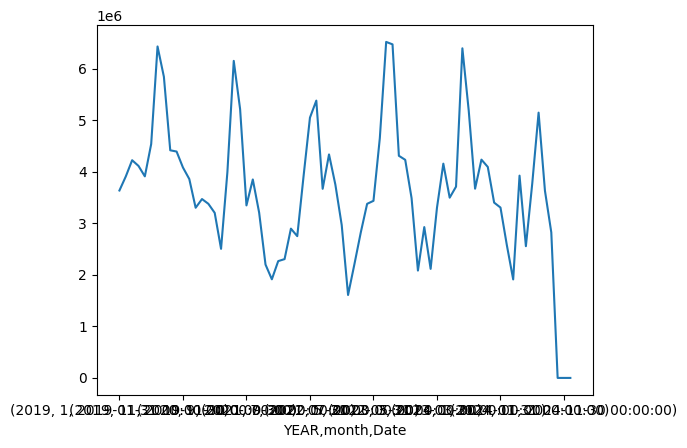

In [273]:
rggi_share.unstack('PJM_tech')[1]['Gas'].plot()

In [274]:
rggi_share['RGGI_share'] = rggi_share[1]/rggi_share[[0,1]].sum(axis=1)

In [306]:
px.line(rggi_share.dropna(subset=['RGGI_share']).pivot_table(index=['month','PJM_tech'],columns='YEAR',values='RGGI_share').loc[:,'Storage',:])

KeyError: 'Storage'

In [285]:
rggi_share.dropna(subset=['RGGI_share']).loc[2022:].reset_index().groupby(['month','PJM_tech']).mean().loc[:,'Gas',:]

C:\Users\Alex Child\AppData\Local\Temp\ipykernel_39220\1356245120.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



RGGI_state,YEAR,0,1,RGGI_share
month,,,,
1,2023.0,2.731808e+07,2.612574e+06,0.086046
2,2023.0,2.497213e+07,2.298886e+06,0.084553
3,2023.0,2.548674e+07,2.677257e+06,0.095574
4,2023.0,1.931289e+07,3.818223e+06,0.165158
5,2023.0,2.248896e+07,3.161682e+06,0.123845
6,2023.0,2.806269e+07,4.042933e+06,0.126768
7,2023.0,3.285904e+07,6.018023e+06,0.155135
8,2023.0,3.229763e+07,5.094455e+06,0.136332
9,2023.0,2.834207e+07,3.600037e+06,0.113015


In [276]:
pjm.groupby(['YEAR','month','Date','PJM_tech','RGGI_state'])['Generation_share_PJM'].sum().unstack('RGGI_state')

RGGI_state                                     0         1
YEAR month Date       PJM_tech                            
2019 1     2019-01-31 Coal              0.962724  0.037276
                      Gas               0.847598  0.152402
                      Hydro             0.764945  0.235055
                      Multiple Fuels    0.839494  0.160506
                      Nuclear           0.843855  0.156145
...                                          ...       ...
2024 12    2024-12-31 Oil               0.000000  0.000000
                      Other             0.000000  0.000000
                      Other Renewables  0.000000  0.000000
                      Solar             0.000000  0.000000
                      Wind              0.000000  0.000000

[717 rows x 2 columns]

In [191]:
rggi_share.dropna(subset=['RGGI_share']).fillna(0).to_csv('RGGI_share_pjm.csv')

## RGGI Compliance Data Compare

In [69]:
import os

In [70]:
RGGI_compliance = pd.read_excel(fr'{os.environ["USERPROFILE"]}\OneDrive - Carbon Cap\Carbon markets research\US Markets\RGGI\RGGI Model.xlsx',sheet_name='R2. RGGI Emissions',header=5)

In [71]:
RGGI_compliance = RGGI_compliance[[ 'Pland Generator ID',
                                                                                        'Year',
                                                                                         'Qtr',
                                                                                 'Source Name',
                                                                                   'ORIS Code',
                                                                                  'Unit ID(s)',
                                                                                       'State',
                                                                                  'State Name',
                                                                            'State Identifier',
                                                                              'Control Period',
                                                                                     'Op Time',
                                                                                    'Op Hours',
                                                                             'CO2 Mass (Tons)',
                                                                          'Heat Input (mmBtu)',
                                                       'Eligible Biomass (Tons) (State Value)',
                                            'Eligible CHP Thermal Output (Tons) (State Value)',
                                                                                           'N',
                                                                 'Compliance Emissions (Tons)',
                                                            'CO2 efficiency (tons/heat input)',
                                                                        'IN EIA 2018 database',
                                                                                  'Technology',
                                                                        'Summer Capacity (MW)',
                           'not subject to 2009-2012 RGGI CO2 allowance compliance obligation',
                           'not subject to 2009-2020 RGGI CO2 allowance compliance obligation',
                           'not subject to 2018-2020 RGGI CO2 allowance compliance obligation',
                           'not subject to 2018-2022 RGGI CO2 allowance compliance obligation',
       '(MD LIESA source - not subject to 2018-2023 RGGI CO2 allowance compliance obligation)',
                                                                       'Quarter Auction Price']]

In [ ]:
RGGI_compliance.groupby(['Year','ORIS Code'])['']

,Pland Generator ID,Year,Qtr,Source Name,ORIS Code,Unit ID(s),State,State Name,State Identifier,Control Period,...,CO2 efficiency (tons/heat input),IN EIA 2018 database,Technology,Summer Capacity (MW),not subject to 2009-2012 RGGI CO2 allowance compliance obligation,not subject to 2009-2020 RGGI CO2 allowance compliance obligation,not subject to 2018-2020 RGGI CO2 allowance compliance obligation,not subject to 2018-2022 RGGI CO2 allowance compliance obligation,(MD LIESA source - not subject to 2018-2023 RGGI CO2 allowance compliance obligation),Quarter Auction Price
0,544_11,2009,1,Devon,544,11,CT,Connecticut,105-14,01/01/2009 - 12/31/2011,...,0.081132,1,Petroleum Liquids,29.2,False,False,False,False,False,3.51
1,544_11,2024,3,Devon,544,11,CT,Connecticut,105-14,01/01/2024 - 12/31/2026,...,0.081011,1,Petroleum Liquids,29.2,False,False,False,False,False,25.75
2,544_12,2024,3,Devon,544,12,CT,Connecticut,105-14,01/01/2024 - 12/31/2026,...,0.081015,1,Petroleum Liquids,29.2,False,False,False,False,False,25.75
3,544_13,2024,3,Devon,544,13,CT,Connecticut,105-14,01/01/2024 - 12/31/2026,...,0.081008,1,Petroleum Liquids,29.9,False,False,False,False,False,25.75
4,544_14,2024,3,Devon,544,14,CT,Connecticut,105-14,01/01/2024 - 12/31/2026,...,0.081006,1,Petroleum Liquids,29.7,False,False,False,False,False,25.75


In [231]:
top_ten_facilities = RGGI_compliance.query('State!="VA"').groupby(['ORIS Code','Year'])['Compliance Emissions (Tons)'].sum().unstack('Year').iloc[:,-5:-1].fillna(0).mean(axis=1).sort_values(ascending=False).head(100).index

In [232]:
rggi_or_pjm_capacity['Qtr'] = rggi_or_pjm_capacity.Date.dt.quarter

In [233]:
def generate_comparison(ID):
    test = RGGI_compliance.query(f'`ORIS Code`=={ID} and Year>2019').sort_values(['Year','Qtr']).groupby(['Year','Qtr'])['Compliance Emissions (Tons)'].sum()
    compare = rggi_or_pjm_capacity.query(f'`Plant Id`=={ID} and YEAR>2019').set_index('Date').groupby(['YEAR','Qtr'])[['Generation MWh','Emissions_stCO2']].sum().reset_index().join(test,on=['YEAR','Qtr'])

    fig = px.scatter(compare,x='Emissions_stCO2',y='Compliance Emissions (Tons)',hover_data=['YEAR','Qtr'],trendline='ols')
    rsqr = px.get_trendline_results(fig).iloc[0][0].rsquared_adj
    
    bar_fig = px.bar(compare[['Emissions_stCO2','Compliance Emissions (Tons)']],barmode='group')

    return fig, rsqr, bar_fig


In [234]:
res_dict = {'ID':['fig','r_sqr','bar_fig']}
for x in top_ten_facilities:
        fig, rsqr, bar_fig = generate_comparison(x)
        res_dict[x]= [fig, rsqr, bar_fig]

C:\Users\Alex Child\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning:

invalid value encountered in scalar divide



res_df = pd.DataFrame.from_dict(res_dict).transpose()
res_df.columns= res_df.iloc[0]
res_df = res_df.iloc[1:]

In [249]:
res_df.iloc[7]['fig']

In [75]:
test = RGGI_compliance.query('`ORIS Code`==1556 and Year>2019').sort_values(['Year','Qtr']).groupby(['Year','Qtr'])['Compliance Emissions (Tons)'].sum()


In [78]:
compare = rggi_or_pjm_capacity.query('`Plant Id`==1556 and YEAR>2019').set_index('Date').groupby(['YEAR','Qtr'])[['Generation MWh','Emissions_stCO2']].sum().reset_index().join(test,on=['YEAR','Qtr'])

In [202]:
fig = px.scatter(compare,x='Emissions_stCO2',y='Compliance Emissions (Tons)',hover_data=['YEAR','Qtr'],trendline='ols')

In [208]:
rsqr = px.get_trendline_results(fig).iloc[0][0].rsquared_adj

In [209]:
rsqr

0.9910721221086272

In [81]:
px.bar(compare[['Emissions_stCO2','Compliance Emissions (Tons)']],barmode='group')

### PJM Compare

In [82]:
pjm = rggi_or_pjm_capacity[rggi_or_pjm_capacity['Balancing\nAuthority Code']=='PJM']

In [83]:
pjm['In_RGGI'] = np.where((pjm['RGGI_state']==1) ,1,0 ) #& (pjm['Nameplate Capacity (MW)']>=25)

C:\Users\Alex Child\AppData\Local\Temp\ipykernel_39220\2863188609.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [84]:
pjm.groupby(['YEAR','month','Reported\nPrime Mover','RGGI_state'])[['Nameplate Capacity (MW)','Generation MWh']].sum().loc[2023].unstack('RGGI_state').tail(20)

KeyError: 'Reported\nPrime Mover'

In [ ]:
6001.4/28784.7

In [ ]:
177179.934/1.314021e+06

In [ ]:
px.bar(pjm.groupby(['Date','In_RGGI'])['Emissions_stCO2'].sum().unstack())

In [ ]:
pjm.columns

In [ ]:
px.bar(pjm.query('Emissions_stCO2>0').groupby(['Date','In_RGGI'])['Nameplate Capacity (MW)'].count().unstack())

In [ ]:
list(pjm.query('YEAR==2023 and Emissions_stCO2>0')['Plant Id'][~(pjm.query('YEAR==2023 and Emissions_stCO2>0')['Plant Id'].isin(pjm.query('YEAR==2024 and Emissions_stCO2>0')['Plant Id'].unique()))].unique())

In [ ]:
pjm.query('YEAR==2023 and `Plant Id`==1353')

In [ ]:
pjm.query('YEAR==2024 and `Plant Id`==1353')

In [ ]:
mega_gen_fuel_df.query('RGGI_state==1 or `Balancing\nAuthority Code`=="PJM" ')

In [ ]:
mega_gen_fuel_df[gen_cols] = mega_gen_fuel_df[gen_cols].replace('...',0).replace('.',0)

In [ ]:
PJM_compare = mega_gen_fuel_df[mega_gen_fuel_df['Balancing\nAuthority Code']=='PJM'].groupby(['RGGI_state','YEAR','Reported\nFuel Type Code'])[gen_cols].mean()

In [ ]:
PJM_compare.columns = [x.split('\n')[-1] for x in PJM_compare.columns]

In [ ]:
PJM_compare = PJM_compare.stack().to_frame('Generation').reset_index()

In [ ]:
PJM_compare['full_date'] = '01/'+PJM_compare['level_3']+'/'+PJM_compare['YEAR'].astype(str) 

In [ ]:
PJM_compare['date'] = pd.to_datetime(PJM_compare['full_date'],format='%d/%B/%Y')

In [ ]:
PJM_compare_pivot = PJM_compare.pivot_table(index='date',columns=['Reported\nFuel Type Code','RGGI_state'],values='Generation')

In [ ]:
PJM_compare_pivot.columns.get_level_values(0).unique()

In [ ]:
px.line(PJM_compare_pivot['BIT'].cumsum())

In [ ]:
gen_cols.append('YEAR')

In [ ]:
px.line(mega_gen_fuel_df.query('`Plant Name`=="Brandon Shores"')[gen_cols].groupby('YEAR').sum().transpose().replace('...',0).cumsum())